In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_paths = [
    "/content/drive/MyDrive/NLP/Plot eval/First/contractnli_gpt_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/First/cuad_gpt_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/First/maud_gpt_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/First/privacyqa_gpt_evaluation_results_reorganized_by_type.json",

    "/content/drive/MyDrive/NLP/Plot eval/Final/contractnli_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/Final/cuad_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/Final/maud_evaluation_results_reorganized_by_type.json",
    "/content/drive/MyDrive/NLP/Plot eval/Final/privacyqa_evaluation_results_reorganized_by_type.json"
]


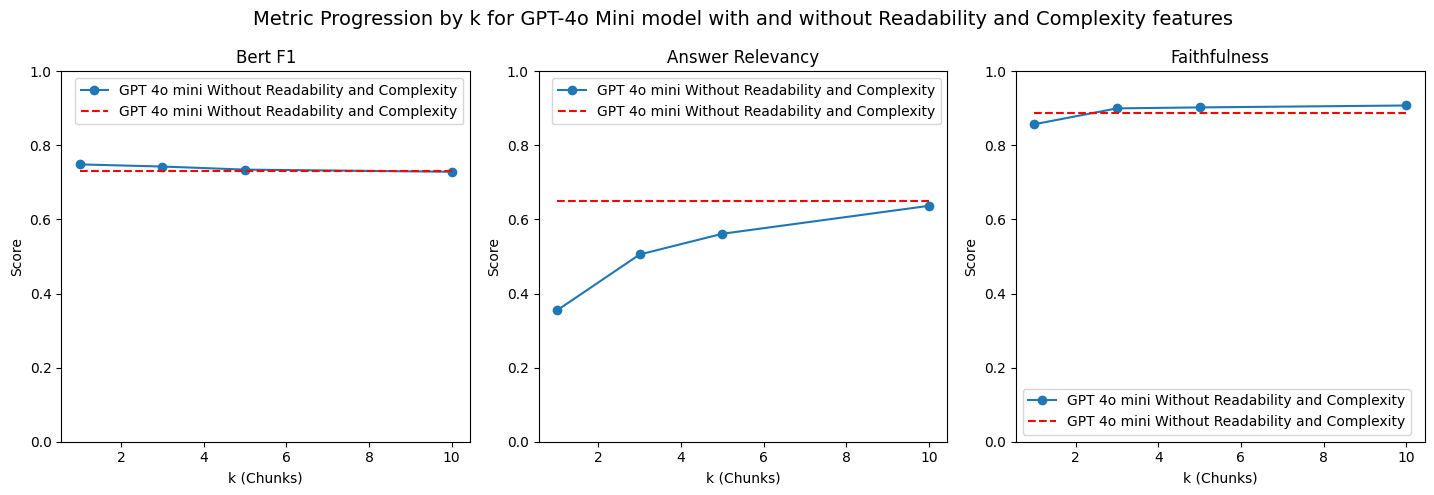

In [15]:
k_metric_values = {m: {} for m in metrics}
human_k10 = {m: [] for m in metrics}

for path in file_paths:
    with open(path, "r") as f:
        data = json.load(f)

        # manually_written k1 to k10
        manual_data = data.get("manually_written", {})
        for k in manual_data:
            k_int = int(k.replace("k", ""))
            metrics_dict = get_metric_values(manual_data[k], k)
            for m in metrics:
                k_metric_values[m].setdefault(k_int, []).append(metrics_dict[m])

        # human_tuned at k10
        human_entry = data.get("human_tuned", {}).get("k10", {})
        if human_entry:
            metrics_dict = get_metric_values(human_entry, "k10")
            for m in metrics:
                human_k10[m].append(metrics_dict[m])

# Averaging and plotting
k_sorted = sorted(set().union(*[set(k_metric_values[m].keys()) for m in metrics]))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx, m in enumerate(metrics):
    ys = [avg(k_metric_values[m].get(k, [])) for k in k_sorted]
    human_y = avg(human_k10[m])

    axs[idx].plot(k_sorted, ys, marker='o', label='GPT 4o mini Without Readability and Complexity')
    axs[idx].hlines(human_y, xmin=min(k_sorted), xmax=max(k_sorted),
                    colors='r', linestyles='dashed', label='GPT 4o mini Without Readability and Complexity')
    axs[idx].set_title(m.replace("_", " ").title())
    axs[idx].set_xlabel("k (Chunks)")
    axs[idx].set_ylabel("Score")
    axs[idx].set_ylim([0, 1])
    axs[idx].legend()

plt.suptitle("Metric Progression by k for GPT-4o Mini model with and without Readability and Complexity features", fontsize=14)
plt.tight_layout()
plt.show()

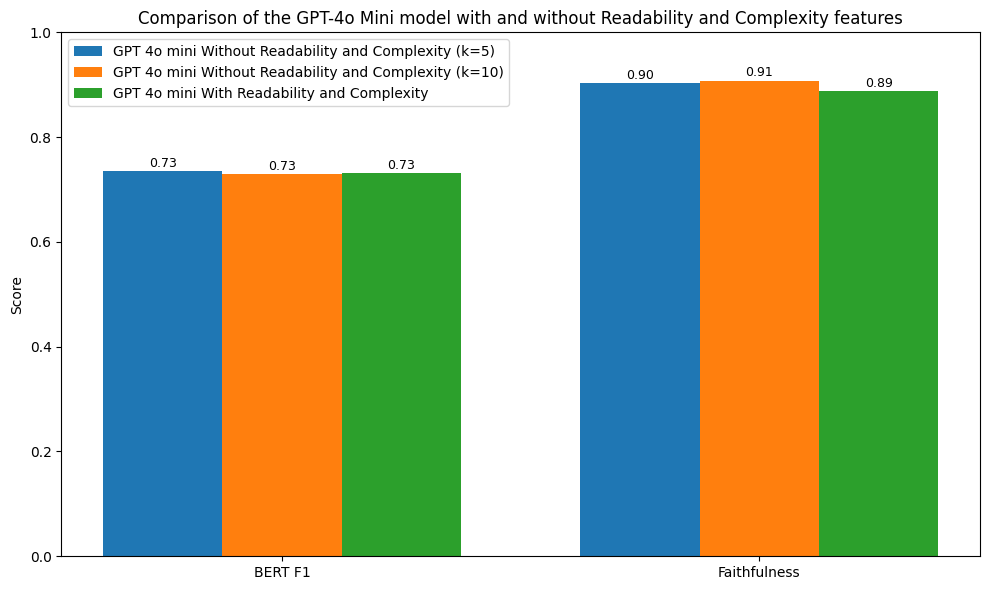

In [3]:
metrics = ["bert_f1", "faithfulness"]
manual_k5 = {m: [] for m in metrics}
manual_k10 = {m: [] for m in metrics}
human_k10 = {m: [] for m in metrics}

def get_metric_values(entry):
    ragas = eval(entry.get("ragas_metrics", "{}"))
    return {
        "bert_f1": entry.get("bert_f1"),
        "faithfulness": ragas.get("faithfulness")
    }

for path in file_paths:
    with open(path, "r") as f:
        data = json.load(f)

        k5_data = data.get("manually_written", {}).get("k5", {})
        if k5_data:
            values = get_metric_values(k5_data)
            for m in metrics:
                manual_k5[m].append(values[m])

        k10_data = data.get("manually_written", {}).get("k10", {})
        if k10_data:
            values = get_metric_values(k10_data)
            for m in metrics:
                manual_k10[m].append(values[m])

        human_data = data.get("human_tuned", {}).get("k10", {})
        if human_data:
            values = get_metric_values(human_data)
            for m in metrics:
                human_k10[m].append(values[m])

def avg(lst): return np.mean(lst) if lst else 0

# Grouped data
k5_avg = [avg(manual_k5[m]) for m in metrics]
k10_avg = [avg(manual_k10[m]) for m in metrics]
human_avg = [avg(human_k10[m]) for m in metrics]

# Plotting
labels = ["BERT F1", "Faithfulness"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, k5_avg, width, label="GPT 4o mini Without Readability and Complexity (k=5)")
bar2 = ax.bar(x, k10_avg, width, label="GPT 4o mini Without Readability and Complexity (k=10)")
bar3 = ax.bar(x + width, human_avg, width, label="GPT 4o mini With Readability and Complexity")

ax.set_ylabel("Score")
ax.set_title("Comparison of the GPT-4o Mini model with and without Readability and Complexity features")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()

# Annotate values
for bar in bar1 + bar2 + bar3:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()